In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

# Filtering and interpolation of axis

In [16]:
import filters

### generate some sample data

In [17]:
## generate some samples
nsamples = 10
samples_t = np.cumsum(np.random.uniform(11,100, nsamples).astype(int))
samples_x = 100 * np.random.random((nsamples))

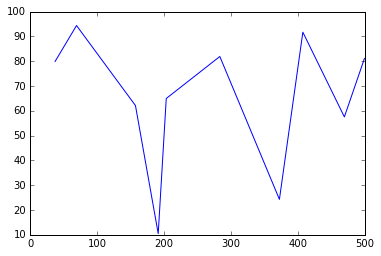

In [18]:
plt.plot(samples_t, samples_x)

## filter with axisfilter

In [19]:
axisfilter = filters.AxisFilter2(10, 2, 10)

In [20]:
t, x = [],[]
for sample_t, sample_x in zip(samples_t, samples_x):
    axisfilter.new_sample(sample_t, sample_x)
    t = np.hstack((t, axisfilter.interpolator.time_steps))
    x = np.hstack((x, axisfilter.samples[:,0]))

## plot both

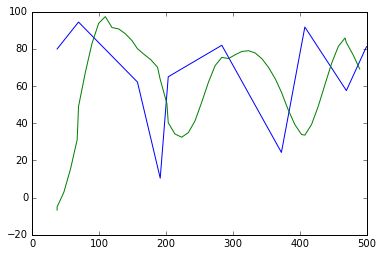

In [21]:
plt.plot(samples_t, samples_x, t, x)

# Using MotionExplorer

In [24]:
import rto

In [136]:
rto = reload(rto)

In [137]:
## generate some samples
nsamples = 1000
samples_t = np.cumsum(np.random.uniform(11,100, nsamples).astype(int))
samples_x = 100 * np.random.random((nsamples))

In [138]:
mexp = rto.MotionExplorer(inputdim = 1)

In [139]:
t, x, d = [],[],[]
for sample_t, sample_x in zip(samples_t, samples_x):
    d_, _ = mexp.new_sample(sample_t, (sample_x, ))
    d = np.hstack((d, [d_]))
    t = np.hstack((t, mexp.axis[0].interpolator.time_steps))
    x = np.hstack((x, mexp.axis[0].samples[:,0]))

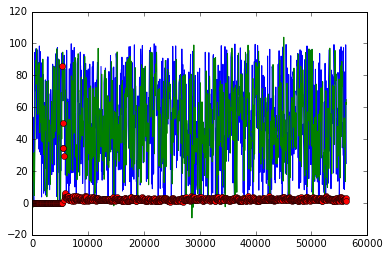

In [145]:
plt.plot(samples_t, samples_x, t, x, samples_t, d, 'o')

In [144]:
samples_t.shape

(1000,)